In [2]:
# Standard libraries
import sys
import os
import time
from pathlib import Path
import glob

# Data processing
import numpy as np
import pandas as pd

# Image processing
import cv2

# Deep learning
import torch
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

print("✓ All imports successful")

✓ All imports successful


In [ ]:
# Create output directory for figures
output_dir = Path('/kaggle/working/optical_flow_figures')
output_dir.mkdir(exist_ok=True, parents=True)

def save_current_figure(filename, dpi=150):
    """
    Save the current matplotlib figure to the output directory.
    
    Args:
        filename: Name of the file to save (e.g., 'flow_comparison.png')
        dpi: Resolution for the saved figure (default: 150)
    """
    filepath = output_dir / filename
    plt.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved figure: {filepath}")

print(f"✓ Output directory created: {output_dir}")
print("✓ save_current_figure() function defined")


In [3]:
# Dataset path
base_dir = Path('/kaggle/input/kitti-drive-2011/2011_09_28/2011_09_28_drive_0038_sync')

# Load image paths
image_paths = sorted(glob.glob(str(base_dir / 'image_02' / 'data' / '*.png')))

# Load timestamps
with open(base_dir / 'image_02' / 'timestamps.txt', 'r') as f:
    timestamps = [line.strip() for line in f.readlines()]

# Create DataFrame
df = pd.DataFrame({
    'frame_id': range(len(image_paths)),
    'timestamp': pd.to_datetime(timestamps),
    'image_path': image_paths
})

print(f"✓ Loaded {len(df)} frames")
print(f"  Duration: {df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]}")
df.head()

✓ Loaded 110 frames
  Duration: 0 days 00:00:11.293573888


frame_id                     timestamp  \
0         0 2011-09-28 12:47:21.706846720   
1         1 2011-09-28 12:47:21.810363904   
2         2 2011-09-28 12:47:21.914002688   
3         3 2011-09-28 12:47:22.017637120   
4         4 2011-09-28 12:47:22.121276672   

                                          image_path  
0  /kaggle/input/kitti-drive-2011/2011_09_28/2011...  
1  /kaggle/input/kitti-drive-2011/2011_09_28/2011...  
2  /kaggle/input/kitti-drive-2011/2011_09_28/2011...  
3  /kaggle/input/kitti-drive-2011/2011_09_28/2011...  
4  /kaggle/input/kitti-drive-2011/2011_09_28/2011...

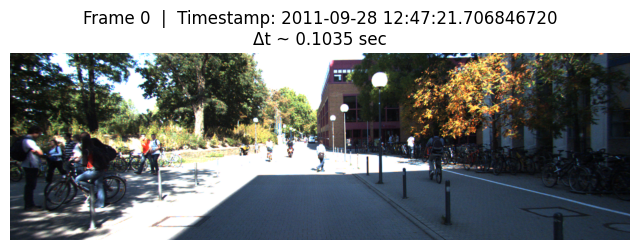

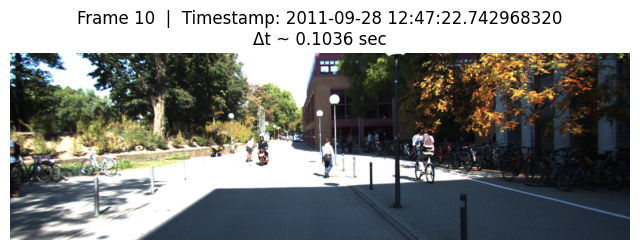

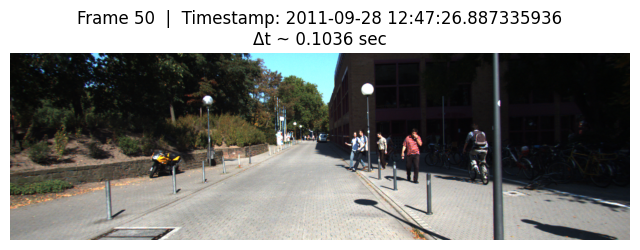

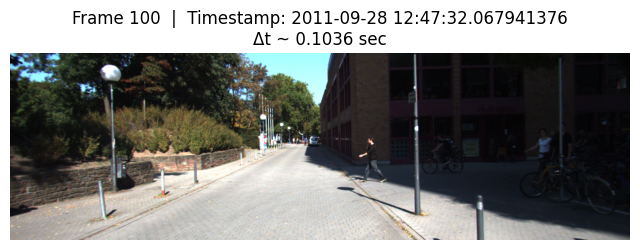

In [4]:
import matplotlib.pyplot as plt

def show_sample_and_velocity(df, idx, save_fig=True):
    """
    Visualizes a sample image and its associated 'velocity'.
    Args:
        df: DataFrame with ['frame_id', 'timestamp', 'image_path']
        idx: Index (int) of sample to show
        save_fig: If True, saves the figure to disk
    """
    img_path = df.iloc[idx]['image_path']
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Compute 'velocity' based on time difference between consecutive frames
    if 0 < idx < len(df)-1:
        t_prev = df.iloc[idx-1]['timestamp']
        t_next = df.iloc[idx+1]['timestamp']
        dt = (t_next - t_prev).total_seconds() / 2
    elif idx == 0 and len(df) > 1:
        dt = (df.iloc[1]['timestamp'] - df.iloc[0]['timestamp']).total_seconds()
    else:
        dt = None

    # Show image
    plt.figure(figsize=(8,4))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Frame {df.iloc[idx]['frame_id']}  |  Timestamp: {df.iloc[idx]['timestamp']}\n"
              + (f"Δt ~ {dt:.4f} sec" if dt is not None else "No Δt"))
    
    if save_fig:
        save_current_figure(f'sample_frame_{idx:03d}.png')
    
    plt.show()

# Example: Visualize a few samples and 'velocities'
for i in [0, 10, 50, 100]:
    if i < len(df):
        show_sample_and_velocity(df, i, save_fig=True)

In [ ]:
def compute_lucas_kanade_optical_flow(img1, img2, feature_params=None, lk_params=None):
    """
    Compute optical flow using Lucas-Kanade method between two consecutive frames.
    
    Args:
        img1: First frame (BGR or grayscale)
        img2: Second frame (BGR or grayscale)
        feature_params: Parameters for corner detection (goodFeaturesToTrack)
        lk_params: Parameters for Lucas-Kanade optical flow
    
    Returns:
        p0: Original feature points (Nx1x2)
        p1: New positions of feature points (Nx1x2)
        status: Status array indicating which points were found
        flow: Flow vectors (Nx2)
    """
    # Convert to grayscale if needed
    if len(img1.shape) == 3:
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    else:
        gray1 = img1
        
    if len(img2.shape) == 3:
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        gray2 = img2
    
    # Default parameters for corner detection
    if feature_params is None:
        feature_params = dict(
            maxCorners=200,        # Maximum number of corners to detect
            qualityLevel=0.01,     # Quality level for corners
            minDistance=15,        # Minimum distance between corners
            blockSize=7            # Size of the averaging block
        )
    
    # Default parameters for Lucas-Kanade optical flow
    if lk_params is None:
        lk_params = dict(
            winSize=(21, 21),      # Size of search window at each pyramid level
            maxLevel=3,            # Maximum pyramid level
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
        )
    
    # Detect features in the first frame
    p0 = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)
    
    if p0 is None:
        return None, None, None, None
    
    # Calculate optical flow using Lucas-Kanade method
    p1, status, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)
    
    # Select good points
    if p1 is not None:
        good_new = p1[status == 1]
        good_old = p0[status == 1]
        
        # Compute flow vectors
        flow = good_new - good_old
        
        return good_old, good_new, status, flow
    else:
        return p0, None, status, None

print("✓ Lucas-Kanade optical flow function defined")


✓ Lucas-Kanade optical flow function defined


In [ ]:
def visualize_optical_flow(img1, img2, p0, p1, draw_tracks=True, draw_dense=False):
    """
    Visualize optical flow results.
    
    Args:
        img1: First frame (BGR)
        img2: Second frame (BGR)
        p0: Original feature points
        p1: New positions of feature points
        draw_tracks: If True, draw motion tracks/vectors
        draw_dense: If True, also show flow magnitude as heatmap
    
    Returns:
        Visualization image
    """
    # Create a copy of the second image
    vis_img = img2.copy()
    
    if p0 is None or p1 is None:
        return vis_img
    
    # Draw tracks
    if draw_tracks:
        for i, (new, old) in enumerate(zip(p1, p0)):
            a, b = new.ravel()
            c, d = old.ravel()
            a, b, c, d = int(a), int(b), int(c), int(d)
            
            # Draw the track (line from old to new position)
            vis_img = cv2.line(vis_img, (c, d), (a, b), (0, 255, 0), 2)
            # Draw circle at new position
            vis_img = cv2.circle(vis_img, (a, b), 5, (0, 0, 255), -1)
    
    return vis_img

def visualize_flow_comparison(df, idx1, idx2=None, feature_params=None, lk_params=None, save_fig=True):
    """
    Compare two consecutive frames with optical flow visualization.
    
    Args:
        df: DataFrame with image paths
        idx1: Index of first frame
        idx2: Index of second frame (if None, uses idx1+1)
        feature_params: Parameters for corner detection
        lk_params: Parameters for Lucas-Kanade
        save_fig: If True, saves the figure to disk
    """
    if idx2 is None:
        idx2 = idx1 + 1
    
    if idx2 >= len(df):
        print(f"Error: idx2 ({idx2}) out of bounds")
        return
    
    # Load images
    img1_path = df.iloc[idx1]['image_path']
    img2_path = df.iloc[idx2]['image_path']
    
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    
    # Compute optical flow
    p0, p1, status, flow = compute_lucas_kanade_optical_flow(
        img1, img2, feature_params, lk_params
    )
    
    if p0 is None or p1 is None:
        print("No optical flow computed")
        return
    
    # Visualize
    vis_img = visualize_optical_flow(img1, img2, p0, p1)
    vis_img_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
    
    # Compute statistics
    flow_magnitude = np.linalg.norm(flow, axis=1)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Original frame 1
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img1_rgb)
    axes[0].set_title(f'Frame {idx1}')
    axes[0].axis('off')
    
    # Original frame 2
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img2_rgb)
    axes[1].set_title(f'Frame {idx2}')
    axes[1].axis('off')
    
    # Optical flow visualization
    axes[2].imshow(vis_img_rgb)
    axes[2].set_title(f'Lucas-Kanade Optical Flow\n{len(p0)} points tracked')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_fig:
        save_current_figure(f'flow_comparison_{idx1:03d}_to_{idx2:03d}.png')
    
    plt.show()
    
    # Print statistics
    print(f"Optical Flow Statistics:")
    print(f"  Points tracked: {len(p0)}")
    print(f"  Mean flow magnitude: {flow_magnitude.mean():.2f} pixels")
    print(f"  Max flow magnitude: {flow_magnitude.max():.2f} pixels")
    print(f"  Min flow magnitude: {flow_magnitude.min():.2f} pixels")

print("✓ Visualization functions defined")


✓ Visualization functions defined


Testing Lucas-Kanade optical flow...


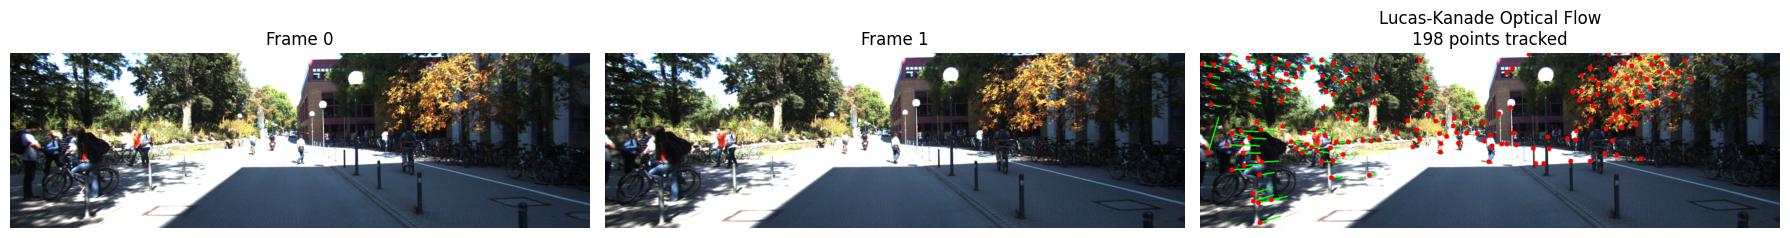

Optical Flow Statistics:
  Points tracked: 198
  Mean flow magnitude: 11.88 pixels
  Max flow magnitude: 78.05 pixels
  Min flow magnitude: 0.70 pixels


In [ ]:
# Test Lucas-Kanade optical flow on consecutive frames
print("Testing Lucas-Kanade optical flow...")
visualize_flow_comparison(df, idx1=0)



Frame pair: 10 -> 11


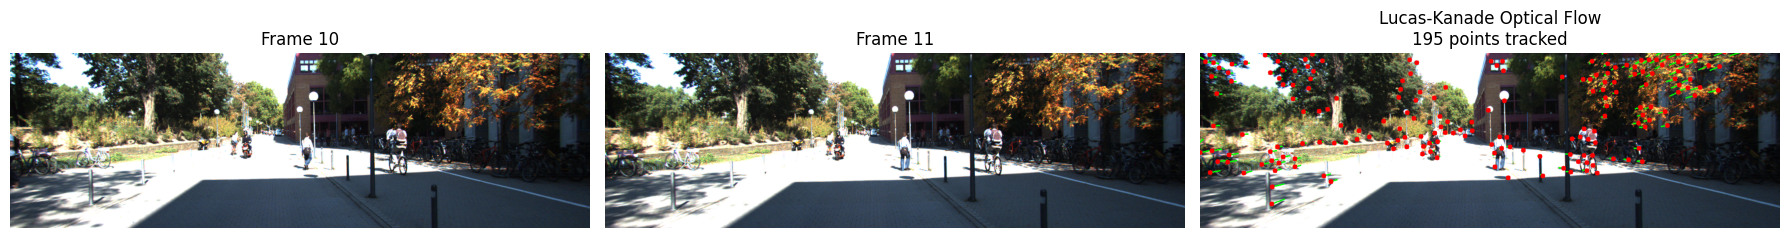

Optical Flow Statistics:
  Points tracked: 195
  Mean flow magnitude: 8.82 pixels
  Max flow magnitude: 29.00 pixels
  Min flow magnitude: 0.15 pixels

Frame pair: 30 -> 31


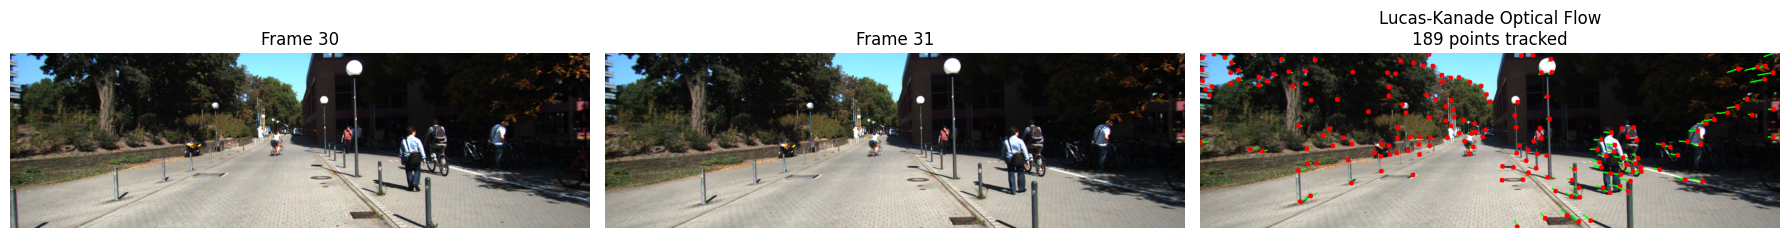

Optical Flow Statistics:
  Points tracked: 189
  Mean flow magnitude: 8.36 pixels
  Max flow magnitude: 33.71 pixels
  Min flow magnitude: 0.64 pixels

Frame pair: 50 -> 51


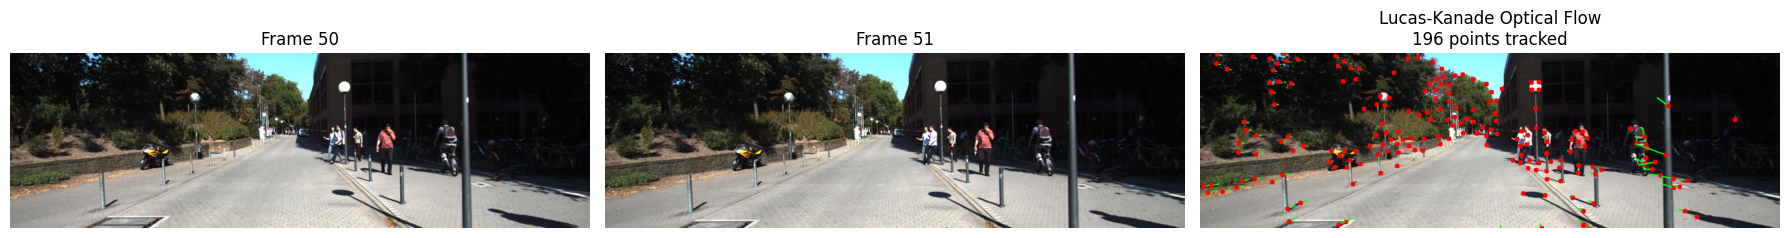

Optical Flow Statistics:
  Points tracked: 196
  Mean flow magnitude: 6.22 pixels
  Max flow magnitude: 67.32 pixels
  Min flow magnitude: 0.02 pixels

Frame pair: 80 -> 81


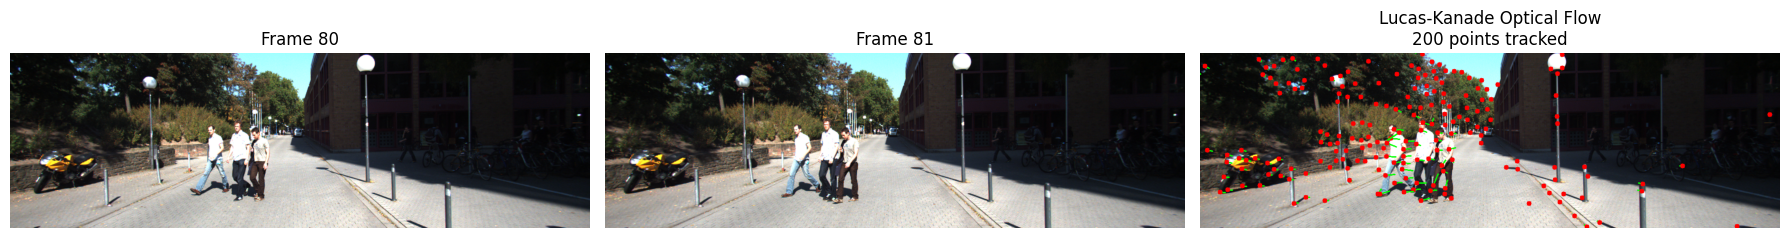

Optical Flow Statistics:
  Points tracked: 200
  Mean flow magnitude: 6.22 pixels
  Max flow magnitude: 29.59 pixels
  Min flow magnitude: 0.45 pixels


In [ ]:
# Test on multiple frame pairs
for idx in [10, 30, 50, 80]:
    if idx < len(df) - 1:
        print(f"\n{'='*60}")
        print(f"Frame pair: {idx} -> {idx+1}")
        print('='*60)
        visualize_flow_comparison(df, idx1=idx, save_fig=True)


In [10]:
def create_flow_video_visualization(df, start_idx=0, end_idx=None, output_path=None):
    """
    Create a video visualization of optical flow through multiple frames.
    
    Args:
        df: DataFrame with image paths
        start_idx: Starting frame index
        end_idx: Ending frame index (if None, uses all frames)
        output_path: Path to save output video (if None, just displays)
    """
    if end_idx is None:
        end_idx = len(df) - 1
    
    end_idx = min(end_idx, len(df) - 1)
    
    # Initialize video writer if output path is provided
    writer = None
    
    print(f"Processing optical flow from frame {start_idx} to {end_idx}...")
    
    flow_magnitudes = []
    
    for idx in tqdm(range(start_idx, end_idx)):
        # Load consecutive frames
        img1 = cv2.imread(df.iloc[idx]['image_path'])
        img2 = cv2.imread(df.iloc[idx + 1]['image_path'])
        
        # Compute optical flow
        p0, p1, status, flow = compute_lucas_kanade_optical_flow(img1, img2)
        
        if p0 is not None and p1 is not None:
            # Visualize
            vis_img = visualize_optical_flow(img1, img2, p0, p1)
            
            # Add frame info
            flow_magnitude = np.linalg.norm(flow, axis=1).mean()
            flow_magnitudes.append(flow_magnitude)
            
            cv2.putText(vis_img, f'Frame: {idx} -> {idx+1}', (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(vis_img, f'Points: {len(p0)}', (10, 70),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(vis_img, f'Avg Flow: {flow_magnitude:.2f}px', (10, 110),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Initialize video writer on first frame
            if writer is None and output_path is not None:
                h, w = vis_img.shape[:2]
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                writer = cv2.VideoWriter(output_path, fourcc, 10.0, (w, h))
            
            # Write frame if writer is initialized
            if writer is not None:
                writer.write(vis_img)
    
    # Release video writer
    if writer is not None:
        writer.release()
        print(f"✓ Video saved to: {output_path}")
    
    # Plot flow magnitude over time
    plt.figure(figsize=(12, 4))
    plt.plot(range(start_idx, start_idx + len(flow_magnitudes)), flow_magnitudes)
    plt.xlabel('Frame Index')
    plt.ylabel('Average Flow Magnitude (pixels)')
    plt.title('Optical Flow Magnitude Over Time')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    save_current_figure(f'flow_magnitude_over_time_{start_idx}_to_{end_idx}.png')
    plt.show()
    
    print(f"\nOverall Statistics:")
    print(f"  Total frames processed: {len(flow_magnitudes)}")
    print(f"  Mean flow magnitude: {np.mean(flow_magnitudes):.2f} pixels")
    print(f"  Max flow magnitude: {np.max(flow_magnitudes):.2f} pixels")
    print(f"  Min flow magnitude: {np.min(flow_magnitudes):.2f} pixels")

print("✓ Video visualization function defined")


✓ Video visualization function defined


Processing optical flow from frame 0 to 109...


100%|██████████| 109/109 [00:04<00:00, 22.59it/s]


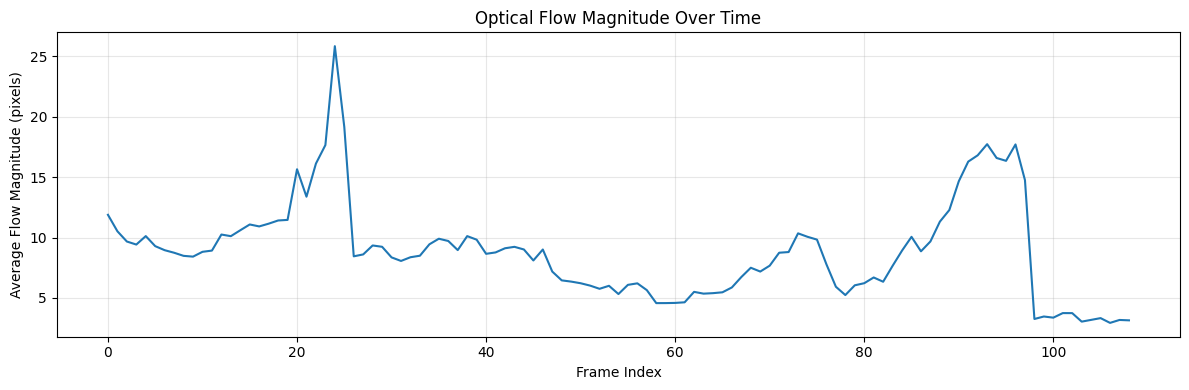


Overall Statistics:
  Total frames processed: 109
  Mean flow magnitude: 8.87 pixels
  Max flow magnitude: 25.83 pixels
  Min flow magnitude: 2.94 pixels


In [11]:
# Analyze optical flow for the entire sequence
create_flow_video_visualization(df, start_idx=0, end_idx=None)


In [ ]:
def flow_to_color(flow, max_flow=None):
    """
    Convert optical flow to color representation using the Middlebury color wheel.
    
    Args:
        flow: Optical flow array (H, W, 2)
        max_flow: Maximum flow magnitude for normalization (auto if None)
    
    Returns:
        RGB image representing flow direction and magnitude
    """
    h, w = flow.shape[:2]
    fx, fy = flow[:, :, 0], flow[:, :, 1]
    
    # Convert to polar coordinates
    ang = np.arctan2(fy, fx) + np.pi
    mag = np.sqrt(fx**2 + fy**2)
    
    # Normalize magnitude
    if max_flow is None:
        max_flow = mag.max()
    if max_flow > 0:
        mag = mag / max_flow
    
    # Create HSV image
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[:, :, 0] = ang * 180 / np.pi / 2  # Hue based on direction
    hsv[:, :, 1] = 255  # Full saturation
    hsv[:, :, 2] = np.clip(mag * 255, 0, 255)  # Value based on magnitude
    
    # Convert to RGB
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

def sparse_flow_to_dense(img_shape, p0, flow):
    """
    Convert sparse Lucas-Kanade flow to dense flow field.
    
    Args:
        img_shape: Shape of the image (H, W) or (H, W, C)
        p0: Original feature points (N, 2)
        flow: Flow vectors (N, 2)
    
    Returns:
        Dense flow field (H, W, 2)
    """
    if len(img_shape) == 3:
        h, w, _ = img_shape
    else:
        h, w = img_shape
    
    # Create empty flow field
    dense_flow = np.zeros((h, w, 2), dtype=np.float32)
    
    # Fill in sparse flow values
    for i, (point, f) in enumerate(zip(p0, flow)):
        x, y = int(point[0]), int(point[1])
        if 0 <= x < w and 0 <= y < h:
            dense_flow[y, x] = f
    
    # Interpolate to fill gaps (simple nearest neighbor fill)
    # For each channel
    for c in range(2):
        mask = (dense_flow[:, :, c] != 0)
        if mask.any():
            from scipy import ndimage
            # Create distance transform
            indices = ndimage.distance_transform_edt(~mask, return_distances=False, return_indices=True)
            dense_flow[:, :, c] = dense_flow[:, :, c][tuple(indices)]
    
    return dense_flow

print("✓ Flow color conversion functions defined")


✓ Flow color conversion functions defined


In [ ]:
def visualize_two_frames_processing(df, idx1=0, idx2=None, save_fig=True):
    """
    Visualize processing of two frames in a 2x2 grid similar to FlowNet visualization.
    
    Args:
        df: DataFrame with image paths
        idx1: Index of first frame
        idx2: Index of second frame (if None, uses idx1+1)
        save_fig: If True, saves the figure to disk
    """
    if idx2 is None:
        idx2 = idx1 + 1
    
    if idx2 >= len(df):
        print(f"Error: idx2 ({idx2}) out of bounds")
        return
    
    # Load images
    img1 = cv2.imread(df.iloc[idx1]['image_path'])
    img2 = cv2.imread(df.iloc[idx2]['image_path'])
    
    # Compute Lucas-Kanade optical flow
    print(f"Computing Lucas-Kanade optical flow between frame {idx1} and {idx2}...")
    p0, p1, status, flow = compute_lucas_kanade_optical_flow(img1, img2)
    
    if p0 is None or p1 is None:
        print("No optical flow computed")
        return
    
    # Convert sparse flow to dense for visualization
    h, w = img1.shape[:2]
    dense_flow = sparse_flow_to_dense((h, w), p0, flow)
    
    # Compute flow magnitude
    mag = np.sqrt(dense_flow[:, :, 0]**2 + dense_flow[:, :, 1]**2)
    
    # Convert flow to color representation
    flow_rgb = flow_to_color(dense_flow)
    
    # Create 2x2 visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Top-left: Frame 1
    axes[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title(f'Frame {idx1}', fontsize=14)
    axes[0, 0].axis('off')
    
    # Top-right: Frame 2
    axes[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title(f'Frame {idx2}', fontsize=14)
    axes[0, 1].axis('off')
    
    # Bottom-left: Optical Flow (color-coded)
    axes[1, 0].imshow(flow_rgb)
    axes[1, 0].set_title('Optical Flow (color-coded)', fontsize=14)
    axes[1, 0].axis('off')
    
    # Bottom-right: Flow Magnitude
    im = axes[1, 1].imshow(mag, cmap='jet')
    axes[1, 1].set_title('Flow Magnitude', fontsize=14)
    axes[1, 1].axis('off')
    plt.colorbar(im, ax=axes[1, 1], fraction=0.046)
    
    plt.tight_layout()
    
    if save_fig:
        save_current_figure(f'two_frames_processing_{idx1:03d}_to_{idx2:03d}.png')
    
    plt.show()
    
    # Print statistics
    flow_magnitude = np.linalg.norm(flow, axis=1)
    print(f"\nLucas-Kanade Optical Flow Statistics:")
    print(f"  Points tracked: {len(p0)}")
    print(f"  Mean flow magnitude: {flow_magnitude.mean():.2f} pixels")
    print(f"  Max flow magnitude: {flow_magnitude.max():.2f} pixels")
    print(f"  Min flow magnitude: {flow_magnitude.min():.2f} pixels")

print("✓ Two-frame processing visualization function defined")


✓ Two-frame processing visualization function defined


Computing Lucas-Kanade optical flow between frame 0 and 1...


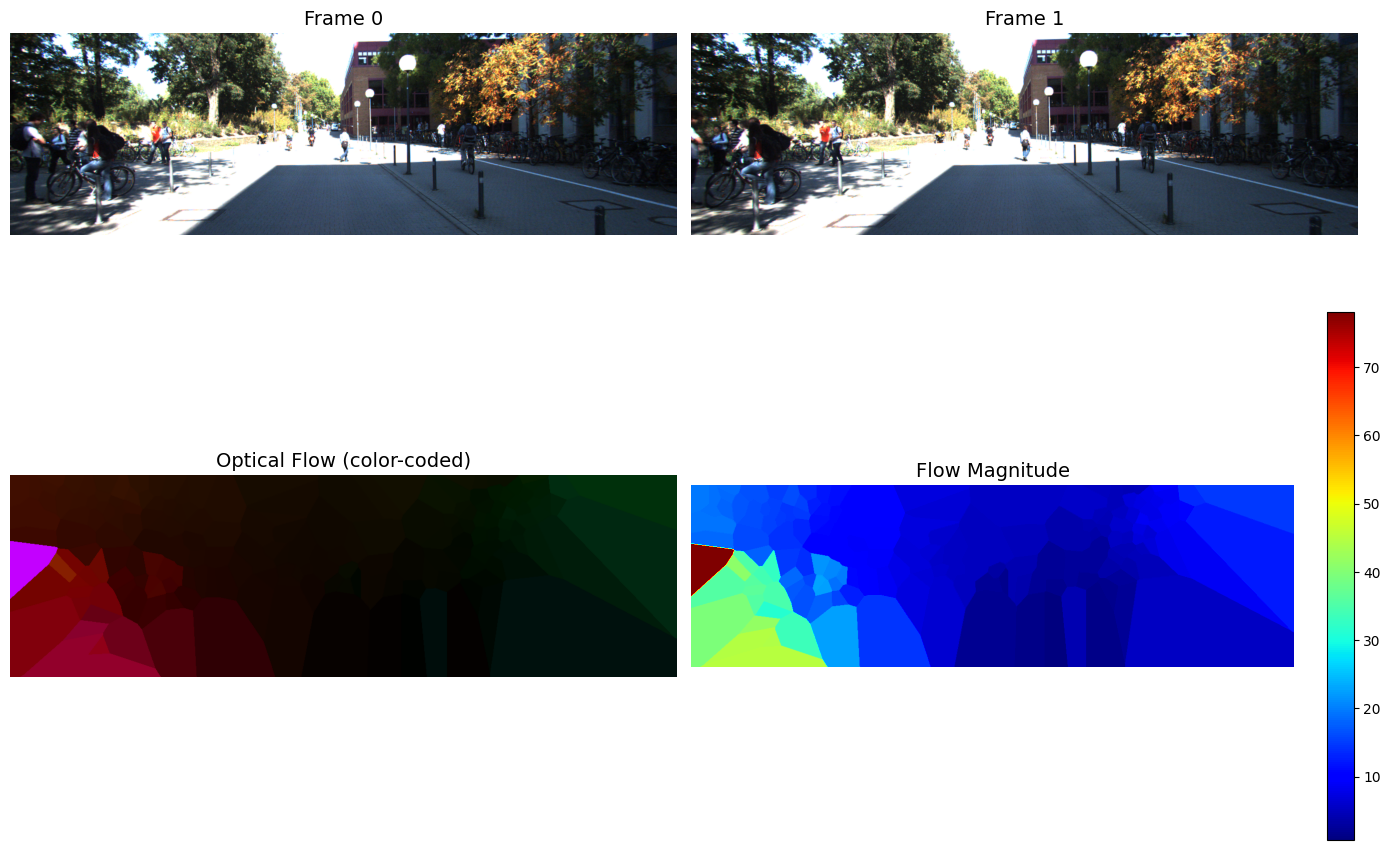


Lucas-Kanade Optical Flow Statistics:
  Points tracked: 198
  Mean flow magnitude: 11.88 pixels
  Max flow magnitude: 78.05 pixels
  Min flow magnitude: 0.70 pixels


In [ ]:
# Visualize processing of two frames (Frame 0 and Frame 1)
visualize_two_frames_processing(df, idx1=0, idx2=1, save_fig=True)


In [ ]:
def visualize_flow_arrows(img, flow, step=16, scale=1.0, arrow_color='yellow', save_fig=True, filename='flow_arrows.png'):
    """
    Visualize optical flow as arrows overlaid on the image.
    Adapted from FlowNet_Clean.ipynb
    
    Args:
        img: Background image (BGR format from cv2)
        flow: Flow field [H, W, 2]
        step: Arrow spacing (sample every N pixels)
        scale: Arrow length scale factor
        arrow_color: Color of arrows ('yellow', 'red', 'white', 'lime', 'cyan', etc.)
        save_fig: If True, saves the figure to disk
        filename: Filename for saved figure
    """
    h, w = flow.shape[:2]
    
    # Create meshgrid for arrow positions
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    
    # Get flow vectors at sampled positions
    fx, fy = flow[y, x].T
    
    # Convert image to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.imshow(img_rgb)
    
    # Plot arrows (quiver plot)
    ax.quiver(x, y, fx, fy, 
              angles='xy', scale_units='xy', scale=1/scale,
              color=arrow_color, width=0.0015, headwidth=4, headlength=5)
    
    ax.set_title('Optical Flow - Arrow Visualization', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    
    if save_fig:
        save_current_figure(filename)
    
    plt.show()

print("✓ visualize_flow_arrows function defined")


✓ visualize_flow_arrows function defined


Computing Lucas-Kanade optical flow between frame 0 and 1...

Visualizing optical flow with arrows...


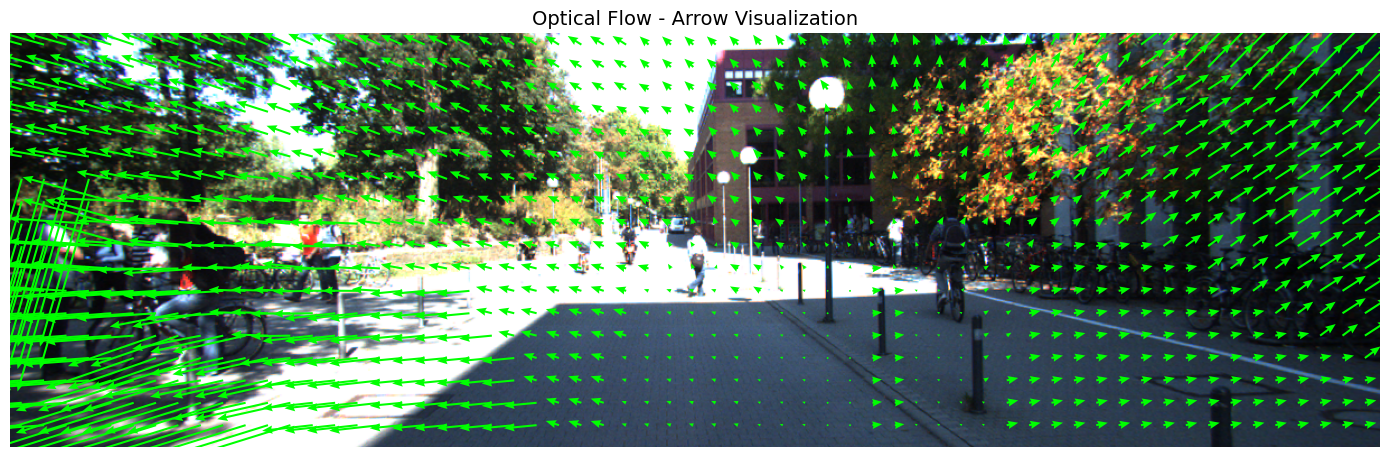

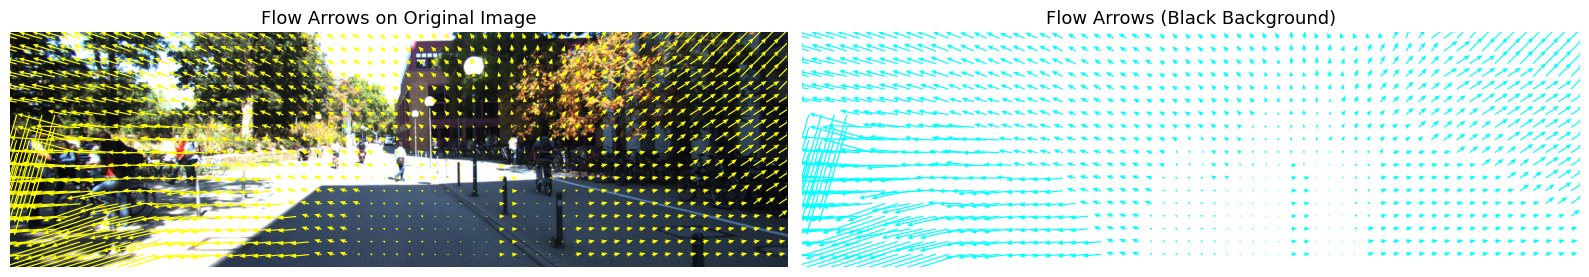

✓ Arrow visualization complete


In [ ]:
# Visualize optical flow with arrows for two frames (similar to FlowNet_Clean.ipynb)
# Load two frames using existing data loading
img1 = cv2.imread(df.iloc[0]['image_path'])
img2 = cv2.imread(df.iloc[1]['image_path'])

# Compute Lucas-Kanade optical flow
print("Computing Lucas-Kanade optical flow between frame 0 and 1...")
p0, p1, status, flow_sparse = compute_lucas_kanade_optical_flow(img1, img2)

if p0 is not None and p1 is not None:
    # Convert sparse flow to dense flow field
    h, w = img1.shape[:2]
    dense_flow = sparse_flow_to_dense((h, w), p0, flow_sparse)
    
    # Visualize with arrows
    print("\nVisualizing optical flow with arrows...")
    visualize_flow_arrows(img1, dense_flow, step=20, scale=2.0, arrow_color='lime', 
                         save_fig=True, filename='flow_arrows_single.png')
    
    # Alternative: Show arrows on darker background for better visibility
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Original with arrows
    y, x = np.mgrid[10:h:20, 10:w:20].reshape(2, -1).astype(int)
    fx, fy = dense_flow[y, x].T
    img_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_rgb)
    axes[0].quiver(x, y, fx, fy, angles='xy', scale_units='xy', scale=0.5,
                   color='yellow', width=0.0015, headwidth=4, headlength=5)
    axes[0].set_title('Flow Arrows on Original Image', fontsize=13)
    axes[0].axis('off')
    
    # Right: Arrows on black background (clearer visualization)
    axes[1].set_facecolor('black')
    axes[1].quiver(x, y, fx, fy, angles='xy', scale_units='xy', scale=0.5,
                   color='cyan', width=0.0015, headwidth=4, headlength=5)
    axes[1].set_xlim(0, w)
    axes[1].set_ylim(h, 0)  # Invert y-axis to match image coordinates
    axes[1].set_title('Flow Arrows (Black Background)', fontsize=13)
    axes[1].set_aspect('equal')
    axes[1].axis('off')
    
    plt.tight_layout()
    save_current_figure('flow_arrows_comparison.png')
    plt.show()
    
    print("✓ Arrow visualization complete")
else:
    print("No optical flow computed")


## Summary of Saved Figures


In [ ]:
# # List all saved figures
# saved_figures = sorted(output_dir.glob('*.png'))

# print("=" * 70)
# print("SAVED FIGURES SUMMARY")
# print("=" * 70)
# print(f"\nOutput directory: {output_dir}")
# print(f"Total figures saved: {len(saved_figures)}\n")

# # Display list of saved figures with file sizes
# for i, fig_path in enumerate(saved_figures, 1):
#     file_size_mb = fig_path.stat().st_size / (1024 * 1024)
#     print(f"{i:2d}. {fig_path.name:<50} ({file_size_mb:.2f} MB)")

# # Calculate total size
# total_size_mb = sum(f.stat().st_size for f in saved_figures) / (1024 * 1024)
# print(f"\nTotal size: {total_size_mb:.2f} MB")
# print("=" * 70)

# # Create a zip file with all figures for easy download
# import zipfile

# zip_path = Path('/kaggle/working/optical_flow_figures.zip')
# with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for fig_path in saved_figures:
#         zipf.write(fig_path, arcname=fig_path.name)

# print(f"\n✓ All figures compressed to: {zip_path}")
# print(f"  Zip file size: {zip_path.stat().st_size / (1024 * 1024):.2f} MB")
# print("\n📥 Download the zip file from the Kaggle output panel!")
